## Assignment 4 - Optiver - Trading at the Close

This notebook was designed for use on Kaggle and was specifically created with that platform in mind.

The tasks performed are as follows:
1. Exploratory Data Analysis (EDA) - performed in order to get an understanding of the dataset.
1. Data Preparation - `near_price` and `far_price` have been removed due to the large amount of missing values. Whereas, all other NaN values were set to 0. Furthermore, the memory usage was reduced by downcasting the data types.
1. Feature Engineering - Addition of features through engineering and removal of some original features due to issues or lack of importance.
1. Model + Evaluation - Testing for overfitting using cross validation with `TimeSeriesSplit` on the training data. Evaluation of a baseline and the modified LightGBM model.

**Future Steps**
This model could be improved with modifications to the hyperparameters with the use of grid search or random search. The creation of additional features, such as with the use of rolling or lagging, could improve it further. Furthermore, there may be some issues with overfitting that still exists that could be dealt with.

_Expert Octo Sniffle_

In [28]:
import numpy as np
import pandas as pd

In [29]:
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

### 1. Exploratory Data Analysis (EDA)

Starting by analyzing the initial DataFrame to determine its features and dataset.

In [30]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [31]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 974.2 MB


In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
stock_id,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760.0,5.715293e+06,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760.0,9.999955e-01,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,5237760.0,4.510025e+07,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638.0,1.001713e+00,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,2380800.0,9.996601e-01,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,5237760.0,9.997263e-01,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


Get the number of missing values in the columns.

In [33]:
df.isna().sum()[lambda x: x > 0]

imbalance_size         220
reference_price        220
matched_size           220
far_price          2894342
near_price         2857180
bid_price              220
ask_price              220
wap                    220
target                  88
dtype: int64

Based on the previous observation, this further calculates the number of rows where either `far_price` or `near_price` is missing.

In [34]:
(df['far_price'].isna() != df['near_price'].isna()).sum()

37162

The analysis reveals that a significant number of values are shared across most features in the dataset. The exception to this trend is the `row_id` feature, which predominantly acts as a unique marker for each dataset entry's position. Distinct differences are observed in features such as `imbalance_size`, `matched_size`, `ask_size`, and `bid_size`.

In [35]:
df.apply(lambda x: pd.Series({
    'nunique': x.nunique(),
    'percentage_unique': x.nunique() / x.count() * 100
})).T

,nunique,percentage_unique
stock_id,200.0,0.003818
date_id,481.0,0.009183
seconds_in_bucket,55.0,0.001050
imbalance_size,2971863.0,56.739198
imbalance_buy_sell_flag,3.0,0.000057
reference_price,28741.0,0.548727
matched_size,2948862.0,56.300060
far_price,95739.0,4.085059
near_price,84625.0,3.554477
bid_price,28313.0,0.540556


### 2. Data Preparation

Drop entries/rows without a`target` as they wont serve any purpose as they are necessary for the training.

In [36]:
df.dropna(subset=['target'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape[0] # Number of rows remaining

5237892

In [37]:
# Compute the actual total memory used by the 'df' DataFrame in megabytes to the nearest tenth.
print('{:.1f} mb'.format(df.memory_usage(deep=True).sum() / 1024**2))

974.2 mb


1. Removal of `far_price` and `near_price` due to the noticably large amount of values missing.
2. Fill remaining initial features

In [38]:
df.drop(['far_price', 'near_price'], axis=1, inplace=True)

df.fillna(0, inplace=True)

In [39]:
print('{:.1f} mb'.format(df.memory_usage(deep=True).sum() / 1024**2))

894.3 mb


#### Reduce Memory By Downcasting Data Types

The memory usage can be reduced through the downcasting of data types.

In [40]:
# These types were determined based on their maximums from the describe()
int_types = {
    'stock_id': 'uint8',
    'date_id': 'uint16',
    'seconds_in_bucket': 'uint16',
    'imbalance_buy_sell_flag': 'int8',
    'time_id': 'uint16'
}

float_types = { col: 'float32' for col in df.select_dtypes('float64').columns }

column_types = int_types | float_types

df = df.astype(column_types)

In [41]:
# Running this again to highlight the reduction in memory usage
print('{:.1f} mb'.format(df.memory_usage(deep=True).sum() / 1024**2))

554.6 mb


### 3. Feature Engineering

Separation of the `target` from the rest of the features.

In [42]:
train = df.drop('target', axis=1)
y = df['target']

In [43]:
def make_features(df):
    data = df.copy() # Create a copy to preserve original
    
    # Ensure that the data is in order.
    data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Drop this column in the 'test' set.
    if 'currently_scored' in data.columns:
        data.drop('currently_scored', axis=1, inplace=True)

    # Indicates the market liquidity and spread, the highest a bidder is willing to pay and the lowest a seller is willing to ask
    data['bid_ask_spread'] = data['ask_price'] - data['bid_price']
    
    # Measures the proportion of order imbalance compared to the volume of orders that can be matched.
    data['imbalance_to_matched_ratio'] = data['imbalance_size'] / data['matched_size']
    
    # Represents the relative time remaining until the market closes, normalized to a scale from 0 to 1.
    data['time_to_close'] = (540 - data['seconds_in_bucket']) / 540
    
    # Highlights price movements for each individual stock
    df['wap_roc'] = df.groupby('stock_id')['wap'].pct_change()
    df['bid_roc'] = df.groupby('stock_id')['bid_price'].pct_change()
    df['ask_roc'] = df.groupby('stock_id')['ask_price'].pct_change()
    
    data.fillna(0, inplace=True)
    
    return data.drop(['time_id', 'date_id', 'row_id'], axis=1)

Apply the changes to the `train` DataFrame to create the new features.

In [44]:
X = make_features(train)

Taking a look at how the newly created features look in the DataFrame.

In [45]:
X.head()

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,bid_ask_spread,imbalance_to_matched_ratio,time_to_close
0,0,0,3180602.750,1,0.999812,13380277.0,0.999812,60651.500000,1.000026,8493.030273,1.000000,0.000214,0.237708,1.000000
1,0,10,1299772.750,1,1.000026,15261107.0,0.999812,13996.500000,1.000026,23519.160156,0.999892,0.000214,0.085169,0.981481
2,0,20,1299772.750,1,0.999919,15261107.0,0.999812,4665.500000,0.999919,12131.599609,0.999842,0.000107,0.085169,0.962963
3,0,30,1299772.750,1,1.000133,15261107.0,1.000026,55998.000000,1.000133,46203.300781,1.000085,0.000107,0.085169,0.944444
4,0,40,1218204.375,1,1.000455,15342675.0,1.000241,14655.950195,1.000455,26610.449219,1.000317,0.000214,0.079400,0.925926


### 4. Model + Evaluation

LightGBM has been chosen as the model for this project due to its high performance and efficiency.

In [46]:
from lightgbm import LGBMRegressor, plot_importance

model = LGBMRegressor()

In [47]:
revealed_targets = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

revealed_targets.dropna(subset=['revealed_target'], inplace=True)

targets = revealed_targets.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket']).copy()
targets.reset_index(drop=True, inplace=True)

y_true = targets['revealed_target']

#### Cross Validation Using TimeSeriesSplit

This will help validate the performance of the model's ability to make predictions.

In [48]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit()

scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')

Usage of a negated MAE in order to minimize the error from sklearn. These scores could be indicative of a well performing model.

In [49]:
print("Cross-Validation MAE Scores (Negated):")
for i, score in enumerate(scores, 1):
    print(f"- Fold {i}: {score:.2f}")

print(f"\nAverage MAE (Mean Absolute Error): {-np.mean(scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(scores):.2f}")

Cross-Validation MAE Scores (Negated):
- Fold 1: -7.48
- Fold 2: -6.92
- Fold 3: -6.22
- Fold 4: -6.45
- Fold 5: -5.99

Average MAE (Mean Absolute Error): 6.61
Standard Deviation of MAE: 0.53


#### Testing Against Example Test Files

This loads in the example test file provided by Optiver and performs the same preparations and feature engineering.

In [50]:
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')

test.drop(['far_price', 'near_price'], axis=1, inplace=True)

X_test = make_features(test)

model.fit(X, y)
y_pred = model.predict(X_test)

The chart below was used to identify some important features, aiding in my decision-making for feature selection.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

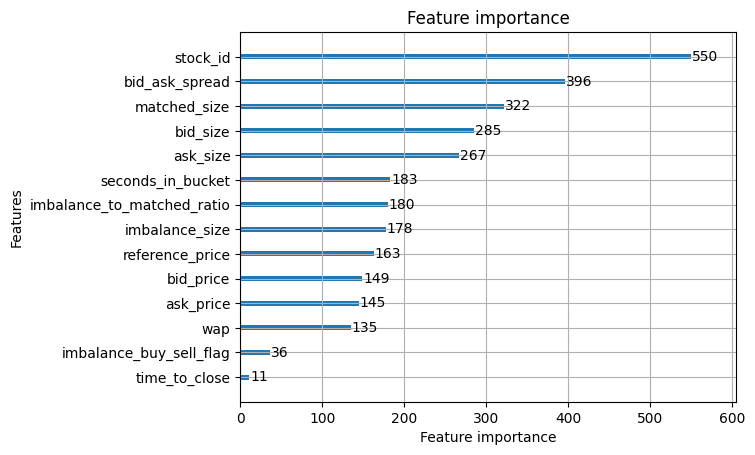

In [51]:
plot_importance(model)

Evaluating the performance on Mean Absolute Error (MAE), the evaluation metric specified. 

In [52]:
score = mean_absolute_error(y_pred, y_true)

#### Comparison to Baseline

In [53]:
model = LGBMRegressor()
model.fit(train.drop('row_id', axis=1), y)
y_pred = model.predict(test.drop(['row_id', 'currently_scored'], axis=1))
y_true = revealed_targets['revealed_target']
baseline = mean_absolute_error(y_pred, y_true)

The improvement from the the baseline unmodified `LGBMRegressor`. By using this model, we already have improvements from the baseline MAE score of 6.41 they provided in the [introduction](https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction).

In [54]:
print(baseline, score)
print(f'Improvement: {baseline - score}')

5.478727832789925 5.391140445376775
Improvement: 0.08758738741315053


#### Forecasting with the Time Series API

If I were participating in the competition, the provided Python time-series API would be integrated at this point in the code. However, as I am not submitting to the competition, this API won't be utilized in my current setup. Theoretically, this is where it would be placed if needed.